In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import trange

# MCMC
import pymc3 as pm
import theano
import theano.tensor as tt
from theano.compile.ops import as_op

def normpdf(x, loc=0, scale=1):
    return 1 / np.sqrt(2*np.pi) / scale * np.exp(-(x-loc)**2 / 2 / scale**2)

def normlogpdf(x, loc=0, scale=1):
    return np.log(1 / np.sqrt(2*np.pi) / scale) - (x-loc)**2 / 2 / scale**2

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
k_base = 1e-8
range_k_log = [2, 6]
range_m = [0, 2]
range_r = [1/3.0, 0]
noise_scale_base = 0.0096
noise_scale_ratio = 0.
    
def get_init_species(init_c):
    O1 = init_c[0]
    O2 = 0.0
    O3 = 0.0
    Cr = init_c[1]
    return np.array([O1, O2, O3, Cr])

def get_species_analy(k1_log, k2_log, m1, m2, r7, init_c, n_data):
    k1 = 10**(k1_log) * k_base
    k2 = 10**(k2_log) * k_base
    t = np.arange(n_data + 1) * dt
    C0 = init_c[0]
    O1 = C0 * np.exp(-k1 * t)
    if k1 != k2:
        O2 = C0 * k1 * (np.exp(-k2 * t) - np.exp(-k1 * t)) / (k1 - k2)
    else:
        O2 = C0 * k2 * t * np.exp(-k2 * t)
    O3 = C0 - O1 - O2
    Cr = init_c[1] - r7 * C0 - r7 * (C0 - O1 + O3)
    return np.c_[O1, O2, O3, Cr]

def get_spectra(k_log, m, r7):
    k1_log, k2_log = k_log
    m1, m2 = m
    spectra = np.array([])
    for k in range(n_set):
        species = get_species(k1_log, k2_log, m1, m2, r7, init_cs[k], n_datas[k])
        Cr = species[:, -1]
        tf = (Cr >= cs_Cr[1]).astype(int)
        sp_Cr = (sps_Cr[tf+1] - sps_Cr[tf]) * ((Cr - cs_Cr[tf]) / (cs_Cr[tf+1] - cs_Cr[tf])).reshape(-1, 1) + sps_Cr[tf]
        spectra = np.append(spectra, sp_Cr.flatten())
    
    return spectra

def get_spectra_noise(g):
    return noise_scale_base + noise_scale_ratio * np.abs(g)

In [3]:
# load standard spectrum of Cr
data_Cr = np.load('../spectra/7+.npy', allow_pickle=True).item()
cs_Cr = np.array(list(data_Cr.keys()))
sps_Cr = list(data_Cr.values())

# load spectra
n_set = 4
init_cs = (
    (
        0.2, # BQDS 
        0.4  # K2Cr2O7
    ),
    (
        0.25,
        0.4
    ),
    (
        0.2,
        0.5
    ),
    (
        0.3,
        0.5
    )
)
file_names = ["../spectra/0.4 mM K2Cr2O7 0.2 mM BQDS/03 0.2 mM BQDS 0.4 mM K2Cr2O7 1 M H2SO4 5 min_Absorbance",
              "../spectra/0.4 mM K2Cr2O7 0.25 mM BQDS/03 0.4 mM K2Cr2O7 0.25 M BQDS 1 M H2SO4 5 min_Absorbance",
              "../spectra/0.5 mM K2Cr2O7 0.2 mM BQDS/03 0.5 mM K2Cr2O7 0.2 mM BQDS 1 M H2SO4 5 min_Absorbance",
              "../spectra/0.5 mM K2Cr2O7 0.3 mM BQDS/03 0.5 mM K2Cr2O7 0.3 mM BQDS 1 M H2SO4 5 min_Absorbance"]
zeros = [3, 4, 4, 4]
n_datas = [288, 280, 88, 224]

dt = 5 * 60
idxs = [437]
spectras = []
data = np.array([])
for k in range(n_set):
    spectra = []
    for i in range(n_datas[k] + 1):
        if zeros[k] == 3:
            file = open(file_names[k] + "_{:03}.txt".format(i))
        elif zeros[k] == 4:
            file = open(file_names[k] + "_{:04}.txt".format(i))
        lines = file.readlines()[14:]
        spectrum = []
        for d in lines:
            tmp = d.split()
            for j in range(len(tmp)):
                tmp[j] = float(tmp[j])
            spectrum.append(tmp)
        spectra.append(spectrum)
    spectra = np.array(spectra)
    spectras.append(spectra)
    data = np.append(data, spectra[:, idxs, 1].flatten())
sps_Cr = np.array([sp[idxs, 1] for sp in sps_Cr])
data[643] = (data[642] + data[644]) / 2.0

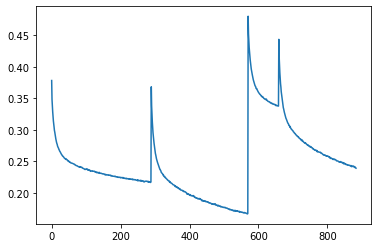

In [4]:
plt.plot(data)

In [5]:
@as_op(itypes=[tt.dvector], 
       otypes=[tt.dvector])
def get_spectra(k_log):
    r7 = 1 / 3.0
    k1_log, k2_log = k_log
    m1, m2 = [1, 1]
    spectra = np.array([])
    for k in range(n_set):
        species = get_species_analy(k1_log, k2_log, m1, m2, r7, init_cs[k], n_datas[k])
        Cr = species[:, -1]
        tf = (Cr >= cs_Cr[1]).astype(int)
        sp_Cr = (sps_Cr[tf+1] - sps_Cr[tf]) * ((Cr - cs_Cr[tf]) / (cs_Cr[tf+1] - cs_Cr[tf])).reshape(-1, 1) + sps_Cr[tf]
        spectra = np.append(spectra, sp_Cr.flatten())
    
    return spectra

@as_op(itypes=[tt.dvector], otypes=[tt.dvector])
def get_spectra_noise(g):
    return noise_scale_base + noise_scale_ratio * np.abs(g)

In [ ]:
with pm.Model() as model:
    k_log = pm.Uniform('k_log', *range_k_log, shape=2)
    g = get_spectra(k_log)
    sigma = get_spectra_noise(g)
    y = pm.Normal('y', mu=g, sd=sigma, observed=data)
    step = pm.Metropolis()
    trace = pm.sample(draws=10000, cores=6, chains=6, tune=10000, step=step, random_seed=0)

In [80]:
def get_spectra(k_log, m, r7):
    k1_log, k2_log = k_log
    m1, m2 = m
    spectra = np.array([])
    for k in range(n_set):
        species = get_species_analy(k1_log, k2_log, m1, m2, r7, init_cs[k], n_datas[k])
        Cr = species[:, -1]
        tf = (Cr >= cs_Cr[1]).astype(int)
        sp_Cr = (sps_Cr[tf+1] - sps_Cr[tf]) * ((Cr - cs_Cr[tf]) / (cs_Cr[tf+1] - cs_Cr[tf])).reshape(-1, 1) + sps_Cr[tf]
        spectra = np.append(spectra, sp_Cr.flatten())
    
    return spectra

def get_spectra_noise(g):
    return noise_scale_base + noise_scale_ratio * np.abs(g)

def get_log_prior(k_log, m, r7):
    return 0

logps = np.zeros(len(trace['k_log']))
for i in trange(len(logps)):
    spectrum = get_spectra(trace['k_log'][i], 
                           [1, 1], 
                           1 / 3.0)
    sigma = get_spectra_noise(spectrum)
    logps[i] = normlogpdf(spectrum, data, sigma).sum() + get_log_prior(trace['k_log'][i], [1,1], 1 / 3)

100%|██████████| 60000/60000 [00:31<00:00, 1934.06it/s]


In [81]:
idx = np.argmax(logps)
print(trace['k_log'][idx][0], trace['k_log'][idx][1])

4.5722424066679475 3.2876921199845137


In [113]:
plt.rcParams['font.family'] = 'Arial'

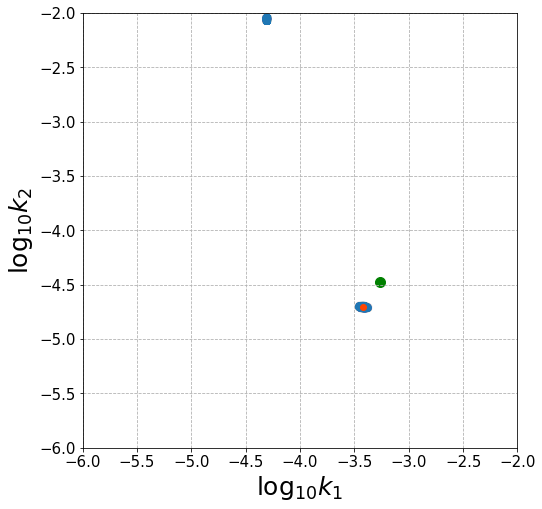

In [106]:
np.set_printoptions(precision=2)
para_name = ['$\log_{10}k_1$', 
             '$\log_{10}k_2$', 
             '$m_1$', '$m_2$']
k_log_true = [k1_log_true[0], k2_log_true[0]]
m_true = [m1_true[0], m2_true[0]]
draw_idxs = [[0,1]]
plt.figure(figsize=(10,8))
for i, draw_idx in enumerate(draw_idxs):
    plt.subplot(1, 1, i+1, aspect='equal')
    plt.scatter(trace['k_log'][:, 0] - 8, trace['k_log'][:, 1] - 8, alpha=0.01)
    plt.scatter(trace['k_log'][idx, 0] - 8, trace['k_log'][idx, 1] - 8, alpha=1, c='orangered')
    plt.scatter(-3.267, -4.476, alpha=1, c='green', s=100)
    plt.xlabel(para_name[draw_idx[0]], fontsize=25)
    plt.ylabel(para_name[draw_idx[1]], fontsize=25)
    if i==1: plt.title('SOC={}'.format(SOC), fontsize=20, y=1.01)
    plt.xlim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.ylim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.grid(ls='--')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
# plt.savefig('chromium_k_post_350nm_fixR_M11.png', bbox_inches='tight')

In [86]:
n_grid = 301
k_log_grid = np.linspace(*range_k_log, n_grid)
K_log_X, K_log_Y = np.meshgrid(k_log_grid, k_log_grid, indexing='ij')
logP = np.zeros(K_log_X.shape)
for i in trange(n_grid):
    for j in range(n_grid):
        k_log_x = K_log_X[i, j]
        k_log_y = K_log_Y[i, j]
        spectrum = get_spectra([k_log_x, k_log_y], 
                           [1, 1], 
                           1 / 3.0)
        sigma = get_spectra_noise(spectrum)
        logP[i, j] = normlogpdf(spectrum, data, sigma).sum() + get_log_prior([k_log_x, k_log_y], [1,1], 1 / 3)

100%|██████████| 301/301 [00:34<00:00,  8.81it/s]


In [17]:
np.where(logP == logP.max())

(array([193]), array([97]))

Text(0, 0.5, '$\\log_{10}k_2$')

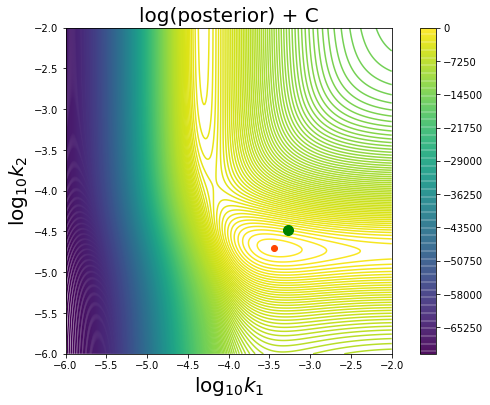

In [107]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 1, 1, aspect='equal')
plt.contour(K_log_X - 8, K_log_Y - 8, logP, levels=300)
plt.colorbar()
plt.scatter(k_log_grid[192] - 8, k_log_grid[97] - 8, c='orangered')
plt.scatter(-3.267, -4.476, alpha=1, c='green', s=100, zorder=10)
plt.title('log(posterior) + C', fontsize=20)
plt.xlabel('$\log_{10}k_1$', fontsize=20)
plt.ylabel('$\log_{10}k_2$', fontsize=20)

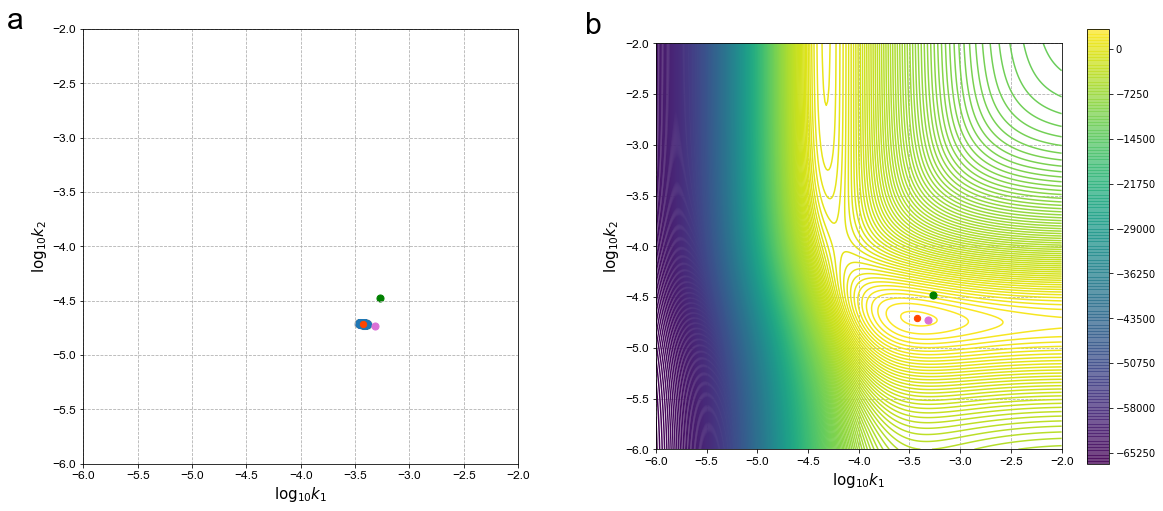

In [177]:
plt.figure(figsize=(20, 8))
para_name = ['$\log_{10}k_1$', 
             '$\log_{10}k_2$', 
             '$m_1$', '$m_2$']
k_log_true = [k1_log_true[0], k2_log_true[0]]
m_true = [m1_true[0], m2_true[0]]
# k_log
draw_idxs = [[0,1]]
for i, draw_idx in enumerate(draw_idxs):
    plt.subplot(1, 2, i+1, aspect='equal')
    plt.scatter(trace['k_log'][:, 0] - 8, trace['k_log'][:, 1] - 8, alpha=0.01)
    plt.scatter(trace['k_log'][idx, 0] - 8, trace['k_log'][idx, 1] - 8, alpha=1, c='orangered', s=40)
#     plt.scatter(-3.268, -4.476, alpha=1, c='green', s=100)
    plt.scatter(-3.267, -4.476, alpha=1, c='green', s=50)
    plt.scatter(-3.32, -4.73, alpha=1, c='orchid', s=50)
    plt.xlabel(para_name[draw_idx[0]], fontsize=15, fontname='Arial')
    plt.ylabel(para_name[draw_idx[1]], fontsize=15, fontname='Arial')
    if i==1: plt.title('SOC={}'.format(SOC), fontsize=20, y=1.01)
#     plt.colorbar(format='%.1f')
#     plt.scatter(k_log_true[draw_idx[0]], k_log_true[draw_idx[1]], c='red')
    plt.xlim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.ylim(range_k_log[0] - 8, range_k_log[1] - 8)
    plt.grid(ls='--')
    plt.xticks(fontsize=12, fontname='Arial')
    plt.yticks(fontsize=12, fontname='Arial')
plt.text(-6.7, -2, 'a', fontsize=30, fontname='Arial')
plt.subplot(1, 2, 2, aspect='equal')
plt.contour(K_log_X - 8, K_log_Y - 8, logP, levels=300)
plt.colorbar()
plt.scatter(k_log_grid[193] - 8, k_log_grid[97] - 8, c='orangered', s=40)
plt.scatter(-3.267, -4.476, alpha=1, c='green', s=50, zorder=10)
plt.scatter(-3.32, -4.73, alpha=1, c='orchid', s=50, zorder=10)
# plt.title('log(unnormalized posterior)', fontsize=15, fontname='Arial')
plt.xlabel('$\log_{10}k_1$', fontsize=15, fontname='Arial')
plt.ylabel('$\log_{10}k_2$', fontsize=15, fontname='Arial')
plt.xticks(fontsize=12, fontname='Arial')
plt.yticks(fontsize=12, fontname='Arial')
plt.text(-6.7, -1.9, 'b', fontsize=30, fontname='Arial')
plt.grid(ls='--')
plt.savefig('chromium_k_post_350nm_fixR_M11.png', bbox_inches='tight')
plt.show()

In [89]:
# generate samples from posterior
n_sample = 1000
sample_idxs = np.random.choice(len(trace['k_log']), n_sample, replace=False)
k1_samples = trace['k_log'][sample_idxs, 0]
k2_samples = trace['k_log'][sample_idxs, 1]
# m1_samples = trace['m'][sample_idxs, 0]
# m2_samples = trace['m'][sample_idxs, 1]
# r7_samples = trace['r7'][sample_idxs]
data_samples = np.zeros((len(data), n_sample))
species_mu = []
species_sigma = []
for k in range(n_set):
    species_samples = []
    for i in range(n_sample):
        k1, k2 = k1_samples[i], k2_samples[i]
        m1, m2 = 1, 1
        r7 = 1 / 3
        species = get_species(k1, k2, m1, m2, r7, init_cs[k], 288)
        species_samples.append(species)
    species_mu.append(np.mean(species_samples, axis=0))
    species_sigma.append(np.std(species_samples, axis=0))

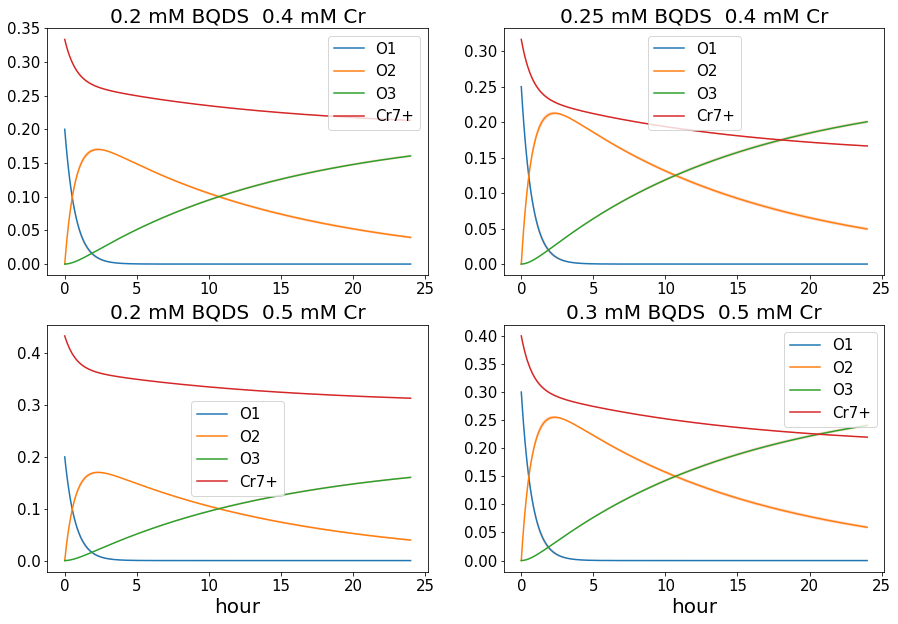

In [149]:
names = ['O1', 'O2', 'O3', 'Cr7+']
plt.figure(figsize=(15, 10))
for k in range(n_set):
    plt.subplot(2, 2, k + 1)
    time = np.arange(len(species_mu[k])) * dt / 3600
    for i in range(4):
        mu = species_mu[k][:, i]
        sigma = species_sigma[k][:, i]
        plt.plot(time, mu, label=names[i])
        plt.fill(np.concatenate([time, time[::-1]]), 
                 np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
                 alpha=.2, fc='orangered', ec='None')
    plt.legend(fontsize=15)
    if k > 1:
        plt.xlabel('hour', fontsize=20)
    plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
# plt.savefig('./chromium_evolution_445nm_fixR_randomM.pdf', bbox_inches='tight')

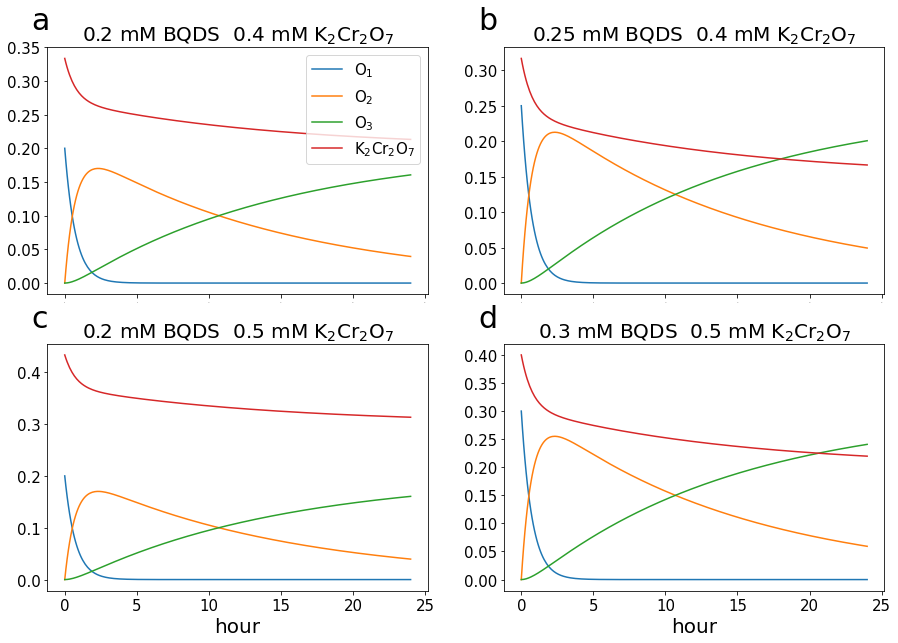

In [90]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(15, 10))
for k in range(n_set):
    plt.subplot(2, 2, k + 1)
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    if k == 0:
        plt.legend(fontsize=15)
    if k > 1:
        plt.xlabel('hour', fontsize=20)
    plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=20)
    if k > 1:
        plt.xticks(fontsize=15)
    else:
        plt.xticks(fontsize=0)
    plt.yticks(fontsize=15)
plt.text(-34, 0.98, 'a', fontsize=30)
plt.text(-3, 0.98, 'b', fontsize=30)
plt.text(-34, 0.45, 'c', fontsize=30)
plt.text(-3, 0.45, 'd', fontsize=30)

plt.savefig('./chromium_evolution_350nm_fixR_M11.pdf', bbox_inches='tight')

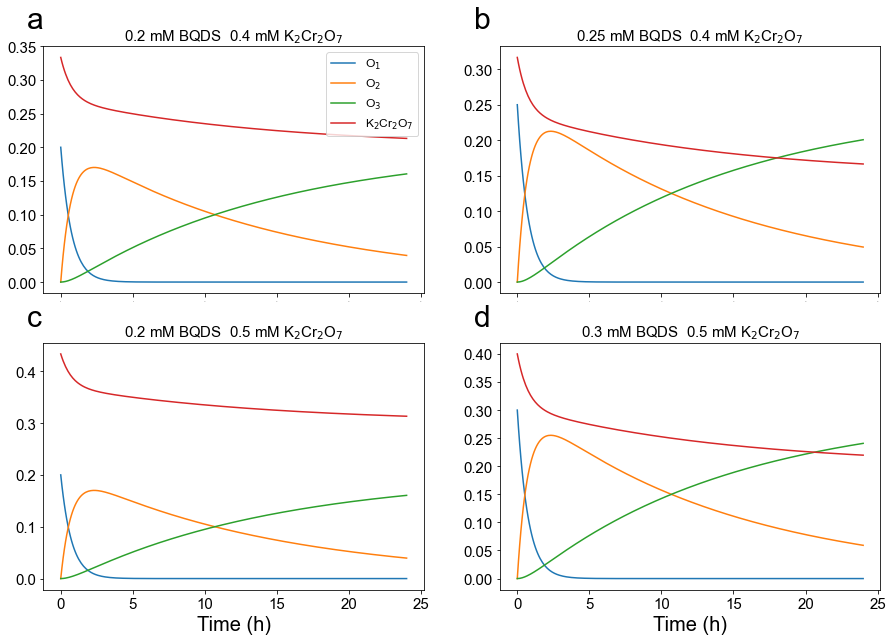

In [145]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(15, 10))
for k in range(n_set):
    plt.subplot(2, 2, k + 1)
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    if k == 0:
        plt.legend(prop={'family':'Arial', 'size':12})
    if k > 1:
        plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
    plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=15, fontname='Arial')
    if k > 1:
        plt.xticks(fontsize=15, fontname='Arial')
    else:
        plt.xticks(fontsize=0)
    plt.yticks(fontsize=15, fontname='Arial')
plt.text(-34, 0.98, 'a', fontsize=30, fontname='Arial')
plt.text(-3, 0.98, 'b', fontsize=30, fontname='Arial')
plt.text(-34, 0.45, 'c', fontsize=30, fontname='Arial')
plt.text(-3, 0.45, 'd', fontsize=30, fontname='Arial')

plt.savefig('./chromium_evolution_350nm_fixR_M11.pdf', bbox_inches='tight')

In [92]:
consumed_crs = []
crs = data.copy()
for k in range(n_set):
    Cr = crs[:n_datas[k]+1]
    crs = crs[n_datas[k]+1:]
    tf = (Cr >= cs_Cr[1]).astype(int)
    sp_Cr = (sps_Cr[tf+1] - sps_Cr[tf]) * ((Cr - cs_Cr[tf]) / (cs_Cr[tf+1] - cs_Cr[tf])).reshape(-1, 1) + sps_Cr[tf]
    sp_Cr = sp_Cr.flatten()
    consumed_cr = (init_cs[k][1] - sp_Cr) * 0.2 / init_cs[k][0]
    consumed_crs.append(consumed_cr)

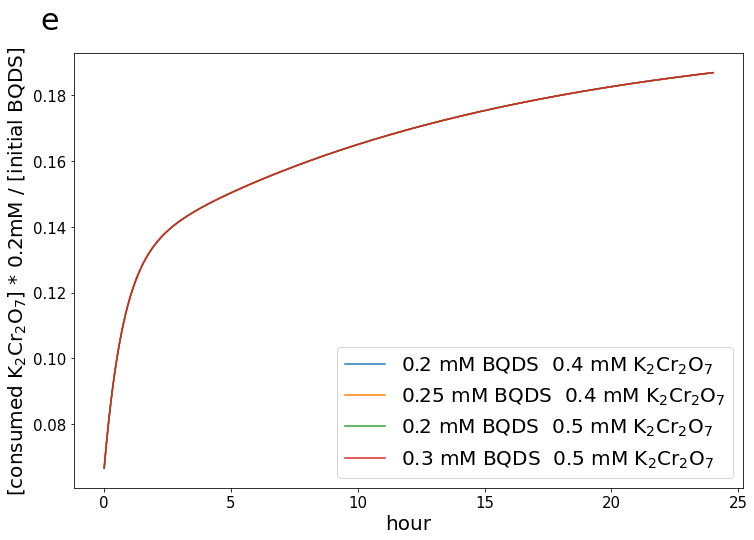

In [93]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
plt.figure(figsize=(12, 8))
for k in range(n_set):
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    plt.plot(time, (init_cs[k][1] - species[:, i]) * 0.2 / init_cs[k][0], 
             label=f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$')
plt.legend(fontsize=20)
plt.xlabel('hour', fontsize=20)
plt.ylabel('[consumed K$_{2}$Cr$_{2}$O$_{7}$] * 0.2mM / [initial BQDS]', fontsize=20)
# plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.text(-2.5, 0.2, 'e', fontsize=30)
plt.savefig('./chromium_consumption_350nm_fixR_M11.pdf', bbox_inches='tight')

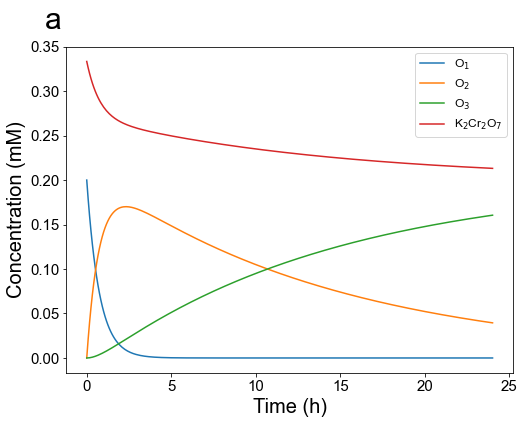

In [163]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(8, 6))
for k in range(1):
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    plt.legend(prop={'family':'Arial', 'size':12})
    plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
    plt.ylabel('Concentration (mM)', fontsize=20, fontname='Arial')
#     plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=15, fontname='Arial')
    plt.xticks(fontsize=15, fontname='Arial')
    plt.yticks(fontsize=15, fontname='Arial')
plt.text(-2.5, 0.37, 'a', fontsize=30, fontname='Arial')

plt.savefig('./chromium_evolution_350nm_fixR_M11_a.pdf', bbox_inches='tight')

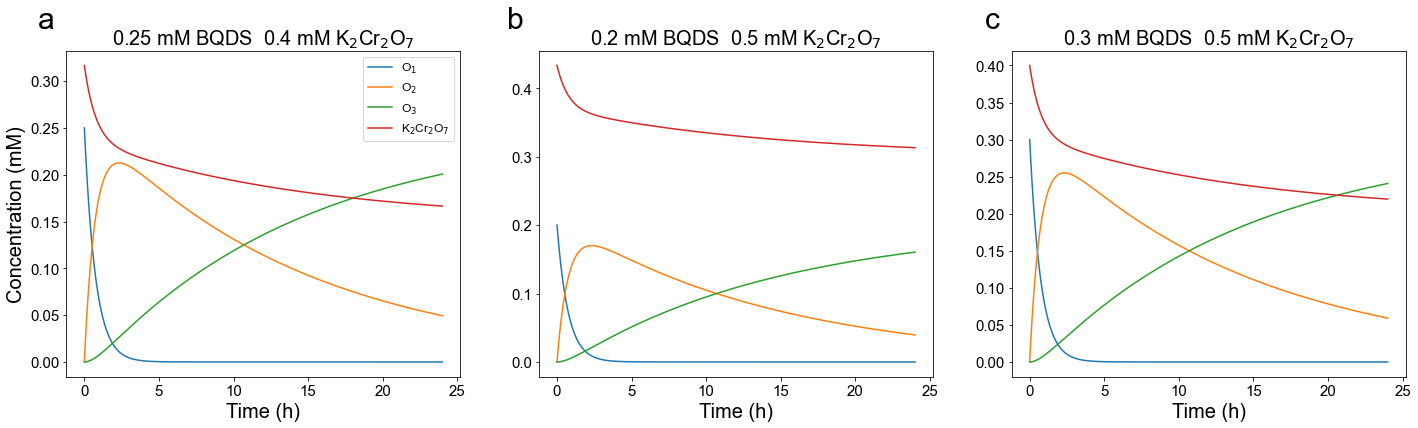

In [173]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(24, 6))
for k in range(1, n_set):
    plt.subplot(1, 3, k)
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    if k == 1:
        plt.legend(prop={'family':'Arial', 'size':12})
        plt.ylabel('Concentration (mM)', fontsize=20, fontname='Arial')
    plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
    plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=20, fontname='Arial')
    plt.xticks(fontsize=15, fontname='Arial')
    plt.yticks(fontsize=15, fontname='Arial')
plt.text(-66.5, 0.45, 'a', fontsize=30, fontname='Arial')
plt.text(-35, 0.45, 'b', fontsize=30, fontname='Arial')
plt.text(-3, 0.45, 'c', fontsize=30, fontname='Arial')
# plt.text(-3, 0.45, 'd', fontsize=30, fontname='Arial')

plt.savefig('./chromium_evolution_350nm_fixR_M11_bcd.pdf', bbox_inches='tight')

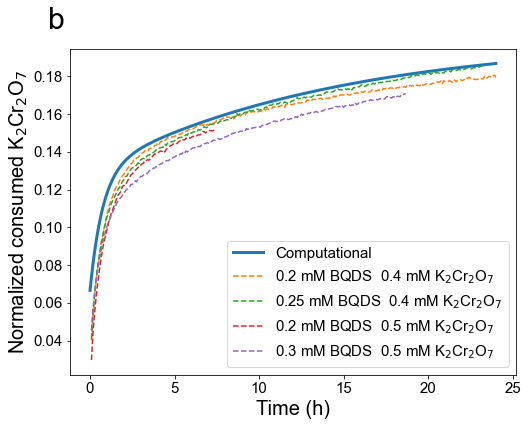

In [164]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
plt.figure(figsize=(8, 6))
k = 0
time = np.arange(len(species_mu[k])) * dt / 3600
species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
plt.plot(time, (init_cs[k][1] - species[:, i]) * 0.2 / init_cs[k][0], 
         label='Computational', lw=3)
for k in range(n_set):
    time = np.arange(n_datas[k] + 1) * dt / 3600
    species = consumed_crs[k]
    plt.plot(time[1:], species[1:], 
             label=f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', ls='--')
plt.legend(prop={'family':'Arial', 'size':15})
plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
# plt.ylabel('[consumed K$_{2}$Cr$_{2}$O$_{7}$] * 0.2mM / [initial BQDS]', fontsize=20, fontname='Arial')
plt.ylabel('Normalized consumed K$_{2}$Cr$_{2}$O$_{7}$', fontsize=20, fontname='Arial')
# plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
plt.xticks(fontsize=15, fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.text(-2.5, 0.205, 'b', fontsize=30, fontname='Arial')
plt.savefig('./chromium_consumption_350nm_fixR_M11.pdf', bbox_inches='tight')

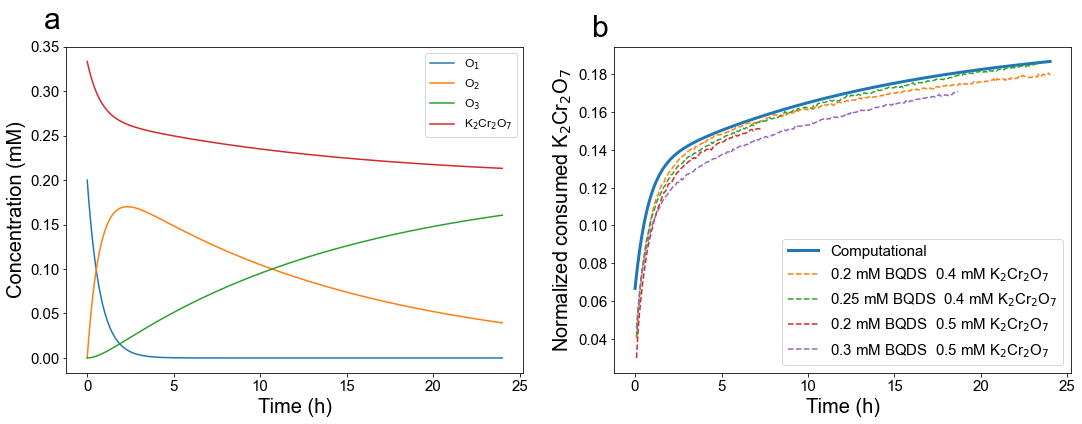

In [186]:
names = ['O$_1$', 'O$_2$', 'O$_3$', 'K$_{2}$Cr$_{2}$O$_{7}$']
fignames = ['a', 'b', 'c', 'd']
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
for k in range(1):
    time = np.arange(len(species_mu[k])) * dt / 3600
    species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
    for i in range(4):
        plt.plot(time, species[:, i], label=names[i])
#         plt.fill(np.concatenate([time, time[::-1]]), 
#                  np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),
#                  alpha=.2, fc='orangered', ec='None')
    plt.legend(prop={'family':'Arial', 'size':12})
    plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
    plt.ylabel('Concentration (mM)', fontsize=20, fontname='Arial')
#     plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', fontsize=15, fontname='Arial')
    plt.xticks(fontsize=15, fontname='Arial')
    plt.yticks(fontsize=15, fontname='Arial')
plt.text(-2.5, 0.37, 'a', fontsize=30, fontname='Arial')

plt.subplot(1, 2, 2)
k = 0
time = np.arange(len(species_mu[k])) * dt / 3600
species = get_species(trace['k_log'][idx][0], trace['k_log'][idx][1], 1, 1, 1 / 3, init_cs[k], 288)
plt.plot(time, (init_cs[k][1] - species[:, i]) * 0.2 / init_cs[k][0], 
         label='Computational', lw=3)
for k in range(n_set):
    time = np.arange(n_datas[k] + 1) * dt / 3600
    species = consumed_crs[k]
    plt.plot(time[1:], species[1:], 
             label=f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM K$_{2}$Cr$_{2}$O$_{7}$', ls='--')
plt.legend(prop={'family':'Arial', 'size':15})
plt.xlabel('Time (h)', fontsize=20, fontname='Arial')
# plt.ylabel('[consumed K$_{2}$Cr$_{2}$O$_{7}$] * 0.2mM / [initial BQDS]', fontsize=20, fontname='Arial')
plt.ylabel('Normalized consumed K$_{2}$Cr$_{2}$O$_{7}$', fontsize=20, fontname='Arial')
# plt.title(f'{init_cs[k][0]} mM BQDS  {init_cs[k][1]} mM Cr', fontsize=20)
plt.xticks(fontsize=15, fontname='Arial')
plt.yticks(fontsize=15, fontname='Arial')
plt.text(-2.5, 0.20, 'b', fontsize=30, fontname='Arial')

plt.savefig('./chromium_evolution_consumption_350nm_fixR_M11.pdf', bbox_inches='tight')